In [3]:
from __future__ import print_function, division

import os
import fnmatch

from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import Isomap, MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.utils.graph import graph_shortest_path
from sklearn.decomposition import KernelPCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import offsetbox

In [4]:
# Scale and visualize the embedding vectors
def plot_embedding(X, X_orig, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(14, 14))
    ax = plt.subplot(111)
    
    xs, ys = X.transpose()
    ax.scatter(xs, ys)

    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(n_samples):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [X[i]]]
        
        img = sp.misc.imresize(X_orig[i, :].reshape(img_height, img_width), (32, 32))
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img, cmap=plt.cm.Greys_r),
            X[i])
        ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [5]:
# read image data and save as vectors
DATA_PATH = 'data/English/Fnt/Sample056'
file_format = '*.png'

img_width, img_height = 128, 128
image_dimension = img_height*img_width
n_samples = 1016

image_vectors = np.empty(shape=(n_samples, image_dimension), dtype='float32')
labels = np.empty(shape=(n_samples, 1), dtype='<S15')

print('Reading image data from:', DATA_PATH)

index = 0
for dirpath, dirs, files in os.walk(DATA_PATH):
    for file_name in fnmatch.filter(files, file_format):
        image_path = os.path.join(dirpath, file_name)
        # read image from file
        image = sp.misc.imread(image_path, flatten=True)
        # flatten image
        image_vector = image.ravel()
        # check that image has the right dimensions
        if image_vector.shape[0] == image_dimension:
            # save image vector
            image_vectors[index, :] = image_vector
            
            # use file name as label for sample
            labels[index, :] = file_name

            index += 1
        else:
            print('Wrong dimensions:', image_path)

print(index, 'images read')
print(np.unique(labels).shape[0], 'unique labels')

Reading image data from: data/English/Fnt/Sample056
1016 images read
1016 unique labels


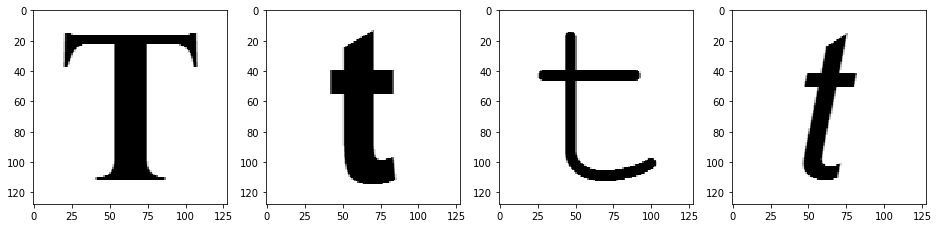

In [6]:
# plot random sample of images from the data set
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 5))
# choose random indices uniformly
random_index = np.random.choice(np.arange(n_samples), size=(4), replace=False)

for col, index in enumerate(random_index):
    # reshape image to original dimensions
    image = image_vectors[index, :].reshape(img_height, img_width)
    # plot image
    ax[col].imshow(image, cmap=plt.cm.Greys_r)

plt.show()

In [26]:
n_neighbors = 10

def metric_isomap_transform(X, n_neighbors=5, radius=None, metric='euclidean'):
    if radius:
        neigh = NearestNeighbors(radius=radius, metric=metric)
    else:
        neigh = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
        
    neigh.fit(X)

    isomap = Isomap(n_neighbors=n_neighbors, n_components=2)

    isomap.kernel_pca_ = KernelPCA(n_components=isomap.n_components,
                                   kernel="precomputed",
                                   eigen_solver='auto',
                                   tol=isomap.tol, max_iter=isomap.max_iter,
                                   n_jobs=isomap.n_jobs)

    kng = kneighbors_graph(neigh, n_neighbors,
                           mode='distance', metric=metric)
    
    isomap.nbrs_ = neigh
    isomap.training_data_ = X
    isomap.dist_matrix_ = graph_shortest_path(kng,
                                              method='auto',
                                              directed=False)

    G = isomap.dist_matrix_ ** 2
    G *= -0.5

    return isomap.kernel_pca_.fit_transform(G)

    
Y = metric_isomap_transform(image_vectors, n_neighbors=n_neighbors, metric='cosine')

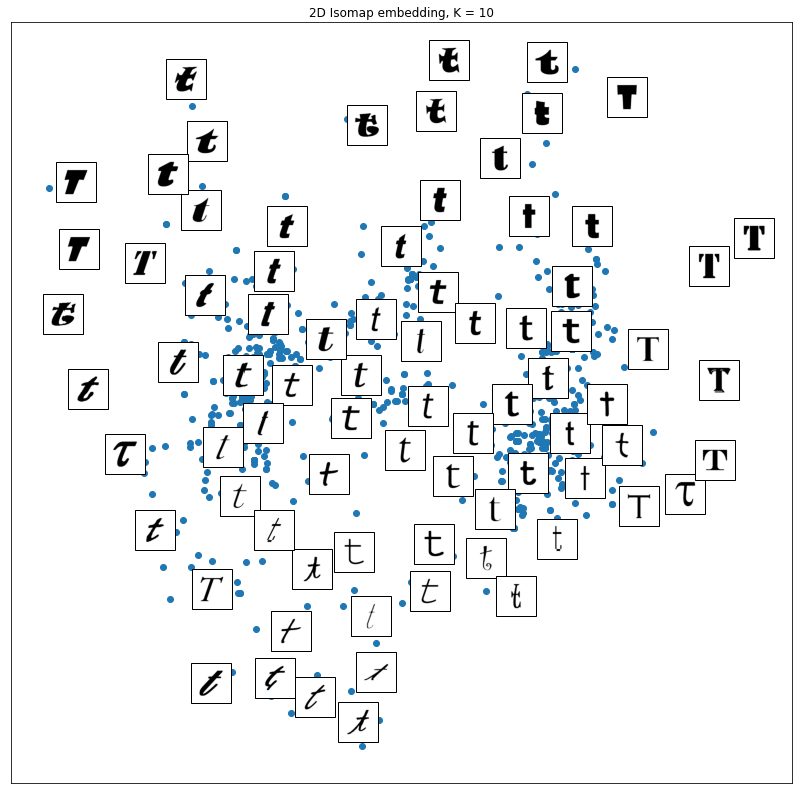

In [30]:
# Create figure
plot_embedding(Y, image_vectors, '2D Isomap embedding, K = {}'.format(n_neighbors))
plt.show()

In [31]:
import pickle

with open('data/mnist.pkl', 'r') as f:
    digits = pickle.load(f)
    
    
y = digits[0][1][digits[0][1] == 2]
X = digits[0][0][digits[0][1] == 2]

img_height, img_width = 28, 28

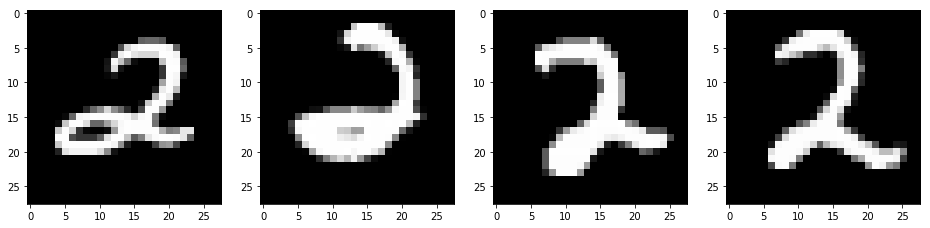

In [32]:
# plot random sample of images from the data set
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 5))
# choose random indices uniformly
random_index = np.random.choice(np.arange(n_samples), size=(4), replace=False)

for col, index in enumerate(random_index):
    # reshape image to original dimensions
    image = X[index, :].reshape(img_height, img_width)
    # plot image
    ax[col].imshow(image, cmap=plt.cm.Greys_r)

plt.show()

In [18]:
Y = metric_isomap_transform(X, n_neighbors=n_neighbors, metric='cosine')

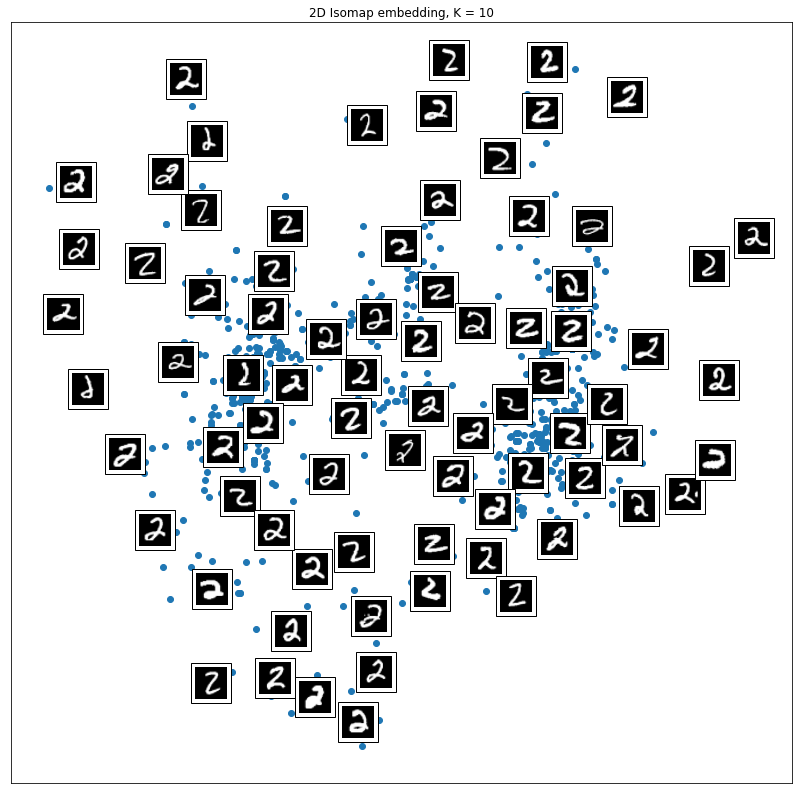

In [33]:
plot_embedding(Y, X, '2D Isomap embedding, K = {}'.format(n_neighbors))
plt.show()